<a href="https://colab.research.google.com/github/ramyamahesh1126/Deep-Learning/blob/Assignment7/RNN_Many_to_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN - Many-to-one
>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.8.0


## Various usage of RNN
RNN is used for sequence data handling. And there are several types of RNN architecture.

## Many-to-one

**Many-to-one** type, gets an sequence data as an input and generates some informatic data like labels. So we can use it for classification. Suppose that someone defines the sentiment of each sentence, and train the model with many-to-one type. And when the model gets the unseen sentence, then it will predict the intention of sentence, good or bad.



## Example - Word sentiment classification



In [2]:
words = ['good', 'bad', 'worse', 'so good']
y = [1, 0, 0, 1]

In [3]:
char_set = ['<pad>'] + sorted(list(set(''.join(words))))
idx2char = {idx:char for idx, char in enumerate(char_set)}
char2idx = {char:idx for idx, char in enumerate(char_set)}

In [4]:
char_set

['<pad>', ' ', 'a', 'b', 'd', 'e', 'g', 'o', 'r', 's', 'w']

In [5]:
idx2char

{0: '<pad>',
 1: ' ',
 2: 'a',
 3: 'b',
 4: 'd',
 5: 'e',
 6: 'g',
 7: 'o',
 8: 'r',
 9: 's',
 10: 'w'}

In [6]:
char2idx

{' ': 1,
 '<pad>': 0,
 'a': 2,
 'b': 3,
 'd': 4,
 'e': 5,
 'g': 6,
 'o': 7,
 'r': 8,
 's': 9,
 'w': 10}

In [7]:
X = list(map(lambda word: [char2idx.get(char) for char in word], words))
X_len = list(map(lambda word: len(word), X))

In [8]:
X

[[6, 7, 7, 4], [3, 2, 4], [10, 7, 8, 9, 5], [9, 7, 1, 6, 7, 7, 4]]

In [9]:
X_len

[4, 3, 5, 7]

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the sequence of indices
max_sequence=10

X = pad_sequences(X, maxlen=max_sequence, padding='post', truncating='post')

In [11]:
X

array([[ 6,  7,  7,  4,  0,  0,  0,  0,  0,  0],
       [ 3,  2,  4,  0,  0,  0,  0,  0,  0,  0],
       [10,  7,  8,  9,  5,  0,  0,  0,  0,  0],
       [ 9,  7,  1,  6,  7,  7,  4,  0,  0,  0]], dtype=int32)

In [12]:
y

[1, 0, 0, 1]

In [13]:
# Generate data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=4).batch(batch_size=2)
print(train_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


After that, we can build many-to-one model with simpleRNN.

In [14]:
input_dim = len(char2idx)
output_dim = len(char2idx)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              mask_zero=True, input_length=max_sequence,
              trainable=False, embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10),
    Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 11)            121       
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                220       
                                                                 
 dense (Dense)               (None, 2)                 22        
                                                                 
Total params: 363
Trainable params: 242
Non-trainable params: 121
_________________________________________________________________


In [16]:
def loss_fn(model, X, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true=y, 
                                                                          y_pred=model(X), 
                                                                          from_logits=True))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [17]:
tr_loss_hist = []

for e in range(30):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x_mb, y_mb)
            
        grads = tape.gradient(tr_loss, sources=model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    if (e + 1) % 5 == 0:
        print('epoch: {:3}, tr_loss: {:3f}'.format(e + 1, avg_tr_loss))

epoch:   5, tr_loss: 0.266653
epoch:  10, tr_loss: 0.030162
epoch:  15, tr_loss: 0.006671
epoch:  20, tr_loss: 0.003246
epoch:  25, tr_loss: 0.002178
epoch:  30, tr_loss: 0.001705


Check the performance of this simple rnn network

In [18]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1)

In [19]:
print('acc: {:.2%}'.format(np.mean(y_pred == y)))

acc: 100.00%


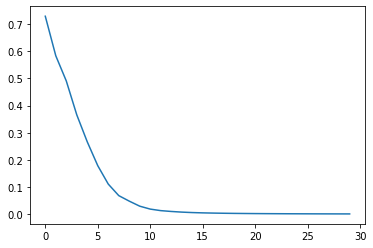

In [20]:
plt.figure()
plt.plot(tr_loss_hist)
plt.show()